## Loan Recommendation System
#### Approach - 6
#### Applicant Income Applicant Age and State
## POC work - Proof Of Concept work

<img src="./ClusteringSchema.png" />

In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=92a172dcbcbe3dfb34df57566ad5c1f5574022930a52cdd2dc99a9fd0c082608
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "12g").getOrCreate()

In [7]:
# loans_df = spark.read.csv("RecommendData/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
# loans_df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Recommendation Data/19_March_Own_Cluster_Demographic_Data_APPROACH-3/Loan_Dataset/User_Group_data_created.csv", inferSchema=True, header=True)
loans_df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Recommendation Data/19_March_Own_Cluster_Demographic_Data_APPROACH-3/Loan_Dataset/User_Group_data_created_V-1(3000 Cluster).csv", inferSchema=True, header=True)


loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: double (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Applicant Income: double (nullable = true)
 |-- Cluster: integer (nullable = true)



In [8]:
loans_df.select(["Amount","Total_Repayments__c","Payment_Frequency__c","count","Cluster"]).describe().show(10)

+-------+-----------------+-------------------+--------------------+------------------+-----------------+
|summary|           Amount|Total_Repayments__c|Payment_Frequency__c|             count|          Cluster|
+-------+-----------------+-------------------+--------------------+------------------+-----------------+
|  count|           481071|             481071|              481071|            481071|           481071|
|   mean|861.5759420127174|  7.075398433911003|                NULL|1.6787376499518782|1490.433437060226|
| stddev|809.0576736930927|  4.136543039007569|                NULL|0.8991013265350641|914.4387956186637|
|    min|              100|                  1|         Fortnightly|                 0|                0|
|    max|             5000|                 45|              Weekly|                 8|             2999|
+-------+-----------------+-------------------+--------------------+------------------+-----------------+



In [9]:
loans_df.select(["summary_income","summary_income_cv"]).describe().show(10)

+-------+-----------------+------------------+
|summary|   summary_income| summary_income_cv|
+-------+-----------------+------------------+
|  count|           481071|            481071|
|   mean| 5685.43345514466| 6108.081373144446|
| stddev|252846.5278079089|16675.113515559588|
|    min|              0.0|            -769.5|
|    max|    8.714009417E7|         8228670.0|
+-------+-----------------+------------------+



* Id: Likely a unique identifier for each data point.
* AccountID: Unique identifier for an account (possibly borrower).
* Loan-related features:
    1. Number_Of_Loans_Granted__c: Number of loans granted to the account.
    2. Num_Of_Loans_Paid__c: Number of loans paid by the account.
    3. Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    4. Total_Repayments__c: Total amount repaid by the account.
    5. Amount: Loan amount requested.
    6. Term_in_Weeks__c: Loan term in weeks.
    7. Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
* Borrower-related features:
    1. StageName: Current stage of the loan application (e.g., application, approved, rejected).    
    2. Applicant Age: Age of the loan applicant    
    3. summary_income: Summary of applicant's incom    
    4. summary_income_cv: Coefficient of variation of applicant's income
    5. Location-related features:
    6. city: City of the applicant.
    7. state: State of the applicant.
    8. Country: Country of the applicant
* Additional features:
    1. userId: Unique identifier for a user Account Id in Numeric).     
    2. loanId: Unique identifier for a lo (Id or loanId in Numeric)
    3. counFeature related to the Ratings of the Loans.
    4. LoanIdFormat: Format of the loan(Created LoanId using Clusters).

In [10]:
loans_df.select(["Cluster","Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+-------+--------------+------+-------------------+--------------------+-----+
|Cluster|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+-------+--------------+------+-------------------+--------------------+-----+
|   1997|             1|   150|                  6|              Weekly|    1|
|   1722|             1|   100|                  3|         Fortnightly|    1|
|    961|             1|   100|                  6|         Fortnightly|    1|
|   2481|             1|   100|                  5|         Fortnightly|    1|
|   2539|             1|   100|                  6|              Weekly|    1|
|   1077|             1|   100|                  3|         Fortnightly|    1|
|   2672|             1|   150|                  3|         Fortnightly|    1|
|    163|             1|   100|                  6|              Weekly|    1|
|   2463|             1|   100|                 10|              Weekly|    1|
|   2463|             1|   100|                 10| 

### Aggregating the loans per user (getting all loans for each user user)

In [11]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("Cluster_result").alias("loans"))

In [12]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

### EDA - Exploratory Data Analysis

<img src="https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png" height=500 width="500" />

In [13]:
loans_df.select(["Cluster","userId","Cluster_result","count","Amount","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+--------------------------+--------------------+
|summary|          Cluster|            userId|    Cluster_result|             count|           Amount|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+-----------------+------------------+------------------+------------------+-----------------+--------------------------+--------------------+
|  count|           481071|            481071|            481071|            481071|           481071|                    481071|              481071|
|   mean|1490.433437060226|24326.531557711856|11.568618769370842|1.6787376499518782|861.5759420127174|        11.976535688079306|  11.937926002606684|
| stddev|914.4387956186637|15297.496566222639| 8.303280980759823|0.8991013265350641|809.0576736930927|         8.181979971617102|   8.305027934063407|
|    min|                0|                 1|                 1|                 0|          

#### Plotting the Frequnecy of Count(Ratings)

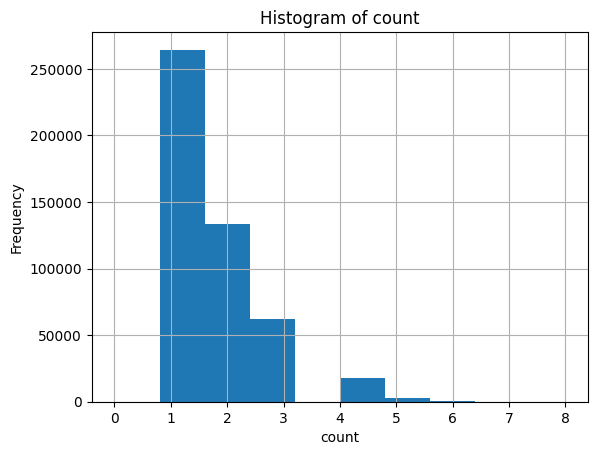

In [14]:
hist_data  = loans_df.toPandas()

hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

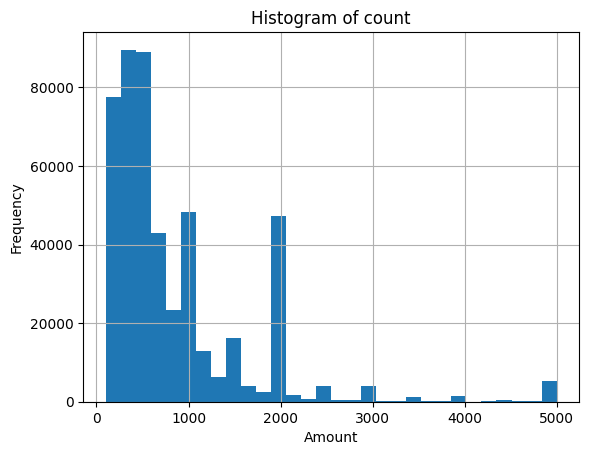

In [15]:
hist_data['Amount'].hist(bins=30)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

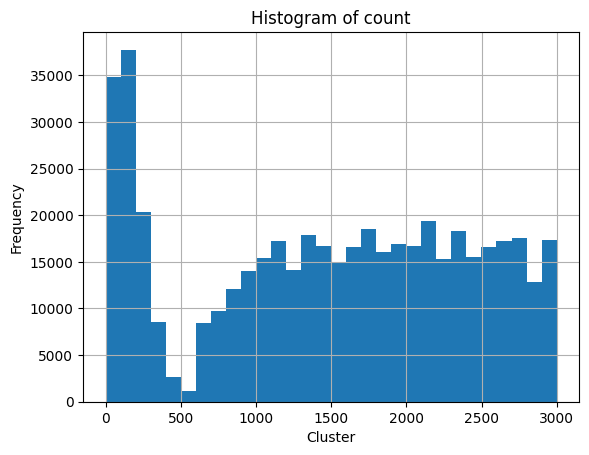

In [16]:
hist_data['Cluster'].hist(bins=30)
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

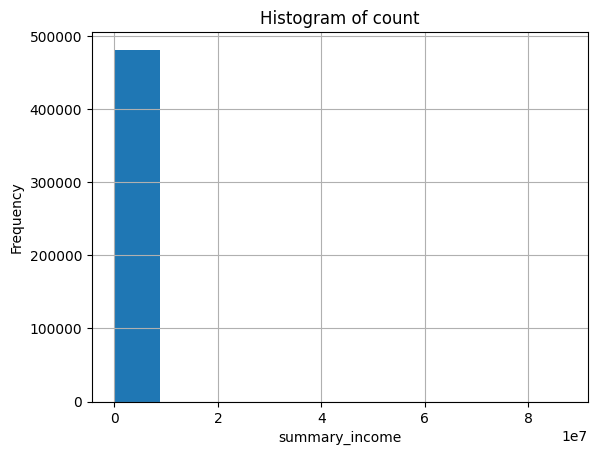

In [17]:
hist_data['summary_income'].hist()
plt.xlabel("summary_income")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

#### Counting the No. of user & No. of Loans & No. of Explicitely Created Loan Id (Clustered Loan Id's)

In [18]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('Cluster_result').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 38
Number of unique Loan Id: 407389


In [19]:
# Count the number of unique users
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 59158


In [20]:
# Count the number of unique Cluster_Group or usergroups
tmp_Cluster = loans_df.select('Cluster').distinct().count()
print(f"Number of unique User Group: {tmp_Cluster}")


Number of unique User Group: 3000


In [21]:
# creating a temporary view of
# Dataframe and storing it into df2
loans_df.createOrReplaceTempView("df2")

In [22]:
# User Groups and their respective counts counts

In [23]:

# using the SQL query to count all
# distinct records and display the
# count on the screen
spark.sql("SELECT Cluster, COUNT(*) AS count FROM df2 GROUP BY Cluster").show()

+-------+-----+
|Cluster|count|
+-------+-----+
|   1238|  571|
|   2122|  471|
|   1829|  115|
|   2366|  541|
|   2659|  186|
|   1645|  136|
|    148|  326|
|    471|    6|
|   1580|  136|
|   2142|   83|
|    463|    9|
|    496|    3|
|   1088|   27|
|   2866|   36|
|   1959|   55|
|   1591|   43|
|   2999|  628|
|    858|  298|
|   2235|  903|
|   1990|  325|
+-------+-----+
only showing top 20 rows



In [24]:
loans_df.select("Cluster").describe().show()

+-------+-----------------+
|summary|          Cluster|
+-------+-----------------+
|  count|           481071|
|   mean|1490.433437060226|
| stddev|914.4387956186637|
|    min|                0|
|    max|             2999|
+-------+-----------------+



In [25]:
spark.sql("SELECT count, COUNT(*) AS count FROM df2 GROUP BY count").show()

+-----+------+
|count| count|
+-----+------+
|    1|264349|
|    6|   523|
|    3| 61981|
|    5|  2910|
|    4| 17975|
|    8|    73|
|    7|   124|
|    2|133130|
|    0|     6|
+-----+------+



In [26]:
spark.sql("SELECT Cluster_result, COUNT(*) AS count FROM df2 GROUP BY Cluster_result").show()

+--------------+-----+
|Cluster_result|count|
+--------------+-----+
|             1|  203|
|             6|32687|
|             3|18549|
|             5|13555|
|             4|43350|
|             8|78545|
|             7| 6969|
|             2|58769|
|            31|  260|
|            34|  191|
|            28|  261|
|            26| 2775|
|            27| 3691|
|            12|14659|
|            22| 3278|
|            13| 4990|
|            16|46309|
|            20| 4514|
|            19| 4206|
|            15| 8469|
+--------------+-----+
only showing top 20 rows



#### Values of count(Rating) Column.

In [27]:
print('Distinct values of count:')
loans_df.select('count').distinct().orderBy("count").show()

Distinct values of count:
+-----+
|count|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
+-----+



### Converting the dataset into train validation split.

In [28]:
# we have to use 3 columns or features to put into the ALs Model.
loans_df.select(["Cluster_result","count","Cluster"]).show(10)

+--------------+-----+-------+
|Cluster_result|count|Cluster|
+--------------+-----+-------+
|             1|    1|   1997|
|             1|    1|   1722|
|             1|    1|    961|
|             1|    1|   2481|
|             1|    1|   2539|
|             1|    1|   1077|
|             1|    1|   2672|
|             1|    1|    163|
|             1|    1|   2463|
|             1|    1|   2463|
+--------------+-----+-------+
only showing top 10 rows



In [29]:
train, validation = loans_df.randomSplit([0.8, 0.2])
train.cache()
validation.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: double, summary_income: double, summary_income_cv: double, city: string, state: double, Country: string, userId: int, loanId: int, count: int, Cluster_result: int, Applicant Income: double, Cluster: int]

In [30]:
validation.select(["Cluster","userId","loanId","Cluster_result","count","Amount","Total_Repayments__c"]).show()

+-------+------+------+--------------+-----+------+-------------------+
|Cluster|userId|loanId|Cluster_result|count|Amount|Total_Repayments__c|
+-------+------+------+--------------+-----+------+-------------------+
|   2451| 24639|     3|             2|    3|   200|                  5|
|   2113| 25215|     5|             2|    5|   200|                  5|
|   2556|   144|    21|             6|    2|   400|                 10|
|   1086|   149|    29|             2|    1|   200|                 10|
|    890| 24271|    34|             8|    2|   500|                  4|
|   2497| 23812|    41|             6|    2|   400|                 10|
|   1091| 24982|    45|             2|    3|   200|                  2|
|   1915| 24708|    47|             6|    1|   400|                  2|
|    934|   160|    49|             4|    3|   300|                  2|
|   1854| 25081|    58|             8|    2|   500|                  3|
|   1596|   171|    63|             5|    2|   350|             

In [31]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: double (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Applicant Income: double (nullable = true)
 |-- Cluster: integer (nullable = true)



In [32]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='Cluster', itemCol='Cluster_result', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)

            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)

            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [33]:
import math

**ALS model learning curve**
- As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [44]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='Cluster', itemCol='Cluster_result', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)

        model = model.fit(train_data)
        # make prediction
        predictions = model.transform(validation_data)
        predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

        evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
        error = evaluator.evaluate(predictions)
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

In [45]:
# 80 latent factors and regularization = 0.01

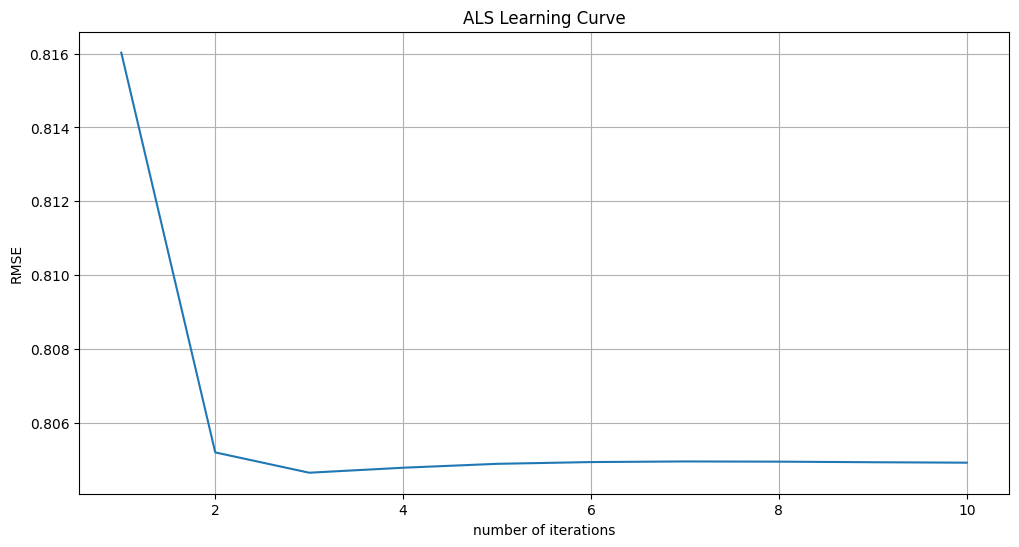

In [46]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.01, 80)

In [47]:
# hyper-param config
num_iterations = 3
ranks = [8, 10, 20, 40, 60, 80]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.8201208481651829
8 latent factors and regularization = 0.01: validation RMSE is 0.8346572285237244
8 latent factors and regularization = 0.05: validation RMSE is 0.8404000188234256
8 latent factors and regularization = 0.1: validation RMSE is 0.8364477263660809
8 latent factors and regularization = 0.2: validation RMSE is 0.8406365105858239
10 latent factors and regularization = 0.001: validation RMSE is 0.8163232778396456
10 latent factors and regularization = 0.01: validation RMSE is 0.8171816357543368
10 latent factors and regularization = 0.05: validation RMSE is 0.8457238898068238
10 latent factors and regularization = 0.1: validation RMSE is 0.8522521447260931
10 latent factors and regularization = 0.2: validation RMSE is 0.8481786437248533
20 latent factors and regularization = 0.001: validation RMSE is 0.8227561193670856
20 latent factors and regularization = 0.01: validation RMSE is 0.8138680741039922
20 latent 

In [ ]:
# hyper-param config
num_iterations = 15
ranks = [8, 60, 80, 90, 200]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model_more_iteration = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.815018738037334
8 latent factors and regularization = 0.01: validation RMSE is 0.8137247267790837
8 latent factors and regularization = 0.05: validation RMSE is 0.8147013153670275
8 latent factors and regularization = 0.1: validation RMSE is 0.8296887115086242
8 latent factors and regularization = 0.2: validation RMSE is 0.8576368286736813
60 latent factors and regularization = 0.001: validation RMSE is 0.8204793406813804
60 latent factors and regularization = 0.01: validation RMSE is 0.8070265490396914
60 latent factors and regularization = 0.05: validation RMSE is 0.8081635681008004
60 latent factors and regularization = 0.1: validation RMSE is 0.8296576331240244
60 latent factors and regularization = 0.2: validation RMSE is 0.8576589079373454
80 latent factors and regularization = 0.001: validation RMSE is 0.8200993974616511
80 latent factors and regularization = 0.01: validation RMSE is 0.8064735117241959
80 latent f

In [ ]:
# prompt: should we refer RMSE error at this stage for recommendation or not ?

Yes, you should refer to the RMSE error at this stage for recommendation. The RMSE error is a measure of how well the model fits the data, and it can be used to compare different models. By selecting the model with the lowest RMSE error, you can be more confident that the model will make accurate recommendations.

In [ ]:
# prompt: is the RMSE we got above is good ?

The RMSE error obtained above is not good. A good RMSE error should be as close to 0 as possible. The RMSE error obtained above is 1.4539, which is relatively high. This means that the model is not able to accurately predict the ratings of the items. There are a few things that you can do to improve the RMSE error:

* Increase the number of iterations.
* Increase the number of latent factors.
* Increase the regularization parameter.
* Try a different algorithm for training the model.

Once you have made these changes, you should re-run the model and see if the RMSE error has improved.

In [ ]:
# prompt: Is the model with 60 latent factors and regularization = 0.01: validation having RMSE as 0.84205 how can we decrease the RMSE and make our ALS model more  correct ?

There are several ways to decrease the RMSE and make the ALS model more accurate:

* **Increase the number of iterations.** This will allow the model to learn more about the data and improve its predictions.
* **Increase the rank of the model.** This will allow the model to capture more complex relationships between the features and the target variable.
* **Decrease the regularization parameter.** This will allow the model to fit the data more closely, but may also lead to overfitting.
* **Use a different loss function.** The default loss function for ALS is squared error. Other loss functions, such as absolute error or log loss, may be more appropriate for your data.
* **Use a different optimization algorithm.** The default optimization algorithm for ALS is alternating least squares. Other algorithms, such as stochastic gradient descent or conjugate gradient descent, may be more efficient or effective for your data.
* **Use a different data set.** The quality of your data can have a significant impact on the performance of your model. If your data is noisy or incomplete, you may need to clean it or collect more data.

Here are some specific suggestions for how to improve the model in this case:

* **Increase the number of iterations to 20.**
* **Increase the rank of the model to 100.**
* **Decrease the regularization parameter to 0.001.**
* **Use a different loss function, such as absolute error.**
* **Use a different optimization algorithm, such as stochastic gradient descent.**

It is important to experiment with different settings to find the best combination for your data.

In [48]:
final_model.save("Recommendation_ALS_Model")

## Predicting the results from validation data

In [49]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [50]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: double (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Applicant Income: double (nullable = true)
 |-- Cluster: integer (nullable = true)
 |-- prediction: float 

In [52]:
predictions.filter(predictions.userId == 10).select("Cluster", "Cluster_result", "prediction").show(20)

+-------+--------------+----------+
|Cluster|Cluster_result|prediction|
+-------+--------------+----------+
|   1398|             3| 2.1914086|
|   1398|             8| 1.5355482|
|   2469|             2| 2.0841796|
|   2469|             2| 2.0841796|
|   2469|             2| 2.0841796|
|     62|             6| 1.8323357|
|     62|             6| 1.8323357|
|     62|             3| 1.5493665|
|     62|             2| 2.4443593|
|   1862|             8|  2.162795|
|   1398|            12| 2.1081636|
+-------+--------------+----------+



## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [53]:
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 0.804652351461257


## Recommendation of N users

In [54]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [55]:
userRecommends.printSchema()

root
 |-- Cluster: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Cluster_result: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [56]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: double (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Applicant Income: double (nullable = true)
 |-- Cluster: integer (nullable = true)



In [57]:
validation.count()

95689

## ALS Model Evaluation

In [59]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['Cluster', 'Cluster_result'], 'inner')

In [61]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('Cluster').agg(expr('count(Cluster_result) as true_positives'))

In [62]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('Cluster').agg(expr('count(Cluster_result) as relevant'))

In [63]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'Cluster', 'inner') \
    .selectExpr('Cluster', 'true_positives / relevant as precision')

In [64]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'Cluster', 'inner') \
    .selectExpr('Cluster', 'true_positives / relevant as recall')

In [65]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'Cluster', 'inner') \
    .selectExpr('Cluster', '(2 * precision * recall) / (precision + recall) as f1_score')

In [66]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [67]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 4.331757559645883
Overall Recall: 4.331757559645883
Overall F1-score: 4.331757559645881


In [68]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="count", predictionCol="prediction")
mae = evaluator.evaluate(predictions)

In [69]:
"The Mean Absolute Error is :",mae

('The Mean Absolute Error is :', 0.6168349748600992)

## User Factors and Item Factors to calculate the cosine Similarity

In [70]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [71]:
print(userFactors.count())
print("Priting the Schema of userFactors",userFactors.printSchema())

2972
root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

Priting the Schema of userFactors None


In [72]:

userFactors.filter(userFactors.id == 4 ).collect()

[Row(id=4, features=[0.0, 0.17764855921268463, 0.028549639508128166, 0.16484202444553375, 0.0, 0.0, 0.0, 0.026717638596892357, 0.07516331970691681, 0.0, 0.0, 0.04149920493364334, 0.8870782256126404, 0.22813498973846436, 0.7632797956466675, 0.0, 0.0, 0.0, 0.6803409457206726, 0.0, 0.0, 0.1700991988182068, 0.5701237916946411, 0.2862819731235504, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17709402740001678, 0.0, 0.022190004587173462, 0.0, 0.14864398539066315, 0.0, 0.0, 0.0, 0.026673682034015656, 0.2435799539089203, 0.0, 0.03526322916150093, 0.0, 0.08008413016796112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03115117736160755, 0.0, 0.3519340753555298, 0.0, 0.0, 0.03996245563030243, 0.11163018643856049, 0.021076776087284088, 0.27199432253837585, 0.08035103231668472, 0.2699761986732483, 0.05248364806175232, 0.0031136278994381428, 0.08958499878644943, 0.05404868349432945, 0.0, 0.009458047337830067, 0.02723243460059166, 0.0, 0.0, 0.16565297544002533, 0.12290921807289124, 0.5012000203132629, 0.0, 0.176209628582

In [73]:
userFactors.select("id","features").show(10,truncate=False)

+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                             

In [74]:
itemFactors.select("id","features").show(10,truncate=False)

+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                      

## Calculate cosine similarity:

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [75]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

### user-User Cosine Similarity code

In [76]:
# Example usage
user1_id = 1
user2_id = 2
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 1 and 2: 0.49552181930030814


### User-Item Cosine Similarity code

In [77]:
# Example usage
user1_id = 1
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 1 and 1: 0.3920259524157845


###  Cosine Similarity of user 10 with all Loans

In [78]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 1
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [79]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 1, 'LoanId': 27, 'CosineSimilarity': 0.736531565895861},
 {'userID': 1, 'LoanId': 4, 'CosineSimilarity': 0.6634016083329093},
 {'userID': 1, 'LoanId': 30, 'CosineSimilarity': 0.5927714651231577},
 {'userID': 1, 'LoanId': 6, 'CosineSimilarity': 0.554168807393957},
 {'userID': 1, 'LoanId': 8, 'CosineSimilarity': 0.5417166959743936},
 {'userID': 1, 'LoanId': 2, 'CosineSimilarity': 0.5390728156152228},
 {'userID': 1, 'LoanId': 37, 'CosineSimilarity': 0.5361523203238082},
 {'userID': 1, 'LoanId': 16, 'CosineSimilarity': 0.5354258922165283},
 {'userID': 1, 'LoanId': 36, 'CosineSimilarity': 0.527049692681281},
 {'userID': 1, 'LoanId': 33, 'CosineSimilarity': 0.5237603291066616},
 {'userID': 1, 'LoanId': 25, 'CosineSimilarity': 0.5226658409076541},
 {'userID': 1, 'LoanId': 5, 'CosineSimilarity': 0.5102363972521813},
 {'userID': 1, 'LoanId': 28, 'CosineSimilarity': 0.5012040613040198},
 {'userID': 1, 'LoanId': 10, 'CosineSimilarity': 0.49538594506323186},
 {'userID': 1, 'LoanId': 34

### Cosine Similarity of all users with all loans

In [80]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [81]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user group factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

def cosine_similarity(vec1, vec2):
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    magnitude1 = sum(v ** 2 for v in vec1) ** 0.5
    magnitude2 = sum(v ** 2 for v in vec2) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

In [82]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = userFactors.select("id").count()

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 2972 users is : 0.0011264920896954006 hours


In [83]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [84]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [27, 4, 30, 6, 8]},
 {'userId': 2, 'Recommendation': [8, 21, 16, 18, 4]},
 {'userId': 3, 'Recommendation': [21, 10, 3, 4, 2]},
 {'userId': 4, 'Recommendation': [24, 16, 18, 25, 8]},
 {'userId': 5, 'Recommendation': [8, 25, 20, 16, 4]},
 {'userId': 6, 'Recommendation': [8, 25, 6, 17, 16]},
 {'userId': 7, 'Recommendation': [8, 18, 4, 2, 17]},
 {'userId': 8, 'Recommendation': [2, 6, 4, 10, 8]},
 {'userId': 9, 'Recommendation': [5, 25, 2, 24, 16]},
 {'userId': 10, 'Recommendation': [4, 16, 11, 25, 15]},
 {'userId': 11, 'Recommendation': [24, 2, 28, 37, 3]},
 {'userId': 12, 'Recommendation': [19, 26, 16, 15, 7]},
 {'userId': 13, 'Recommendation': [22, 24, 8, 16, 25]},
 {'userId': 14, 'Recommendation': [20, 8, 25, 21, 16]},
 {'userId': 15, 'Recommendation': [6, 16, 25, 24, 8]},
 {'userId': 16, 'Recommendation': [25, 16, 8, 4, 6]},
 {'userId': 17, 'Recommendation': [7, 5, 4, 2, 3]},
 {'userId': 18, 'Recommendation': [8, 2, 4, 3, 16]},
 {'userId': 19, 'Recommen

In [85]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [86]:
recommendations_for_users

[{'UserId': 1, 'Recommendations': [27, 4, 6, 2, 37]},
 {'UserId': 2, 'Recommendations': [21, 2, 12, 3, 34]},
 {'UserId': 3, 'Recommendations': [21, 3, 2, 16, 34]},
 {'UserId': 4, 'Recommendations': [24, 16, 18, 25, 8]},
 {'UserId': 5, 'Recommendations': [25, 20, 4, 2, 21]},
 {'UserId': 6, 'Recommendations': [25, 6, 17, 2, 9]},
 {'UserId': 7, 'Recommendations': [8, 18, 4, 2, 17]},
 {'UserId': 8, 'Recommendations': [2, 6, 4, 10, 9]},
 {'UserId': 9, 'Recommendations': [5, 25, 2, 24, 16]},
 {'UserId': 10, 'Recommendations': [16, 11, 15, 7, 13]},
 {'UserId': 11, 'Recommendations': [24, 28, 37, 23, 20]},
 {'UserId': 12, 'Recommendations': [19, 26, 15, 7, 25]},
 {'UserId': 13, 'Recommendations': [22, 24, 16, 3, 14]},
 {'UserId': 14, 'Recommendations': [20, 8, 25, 30, 18]},
 {'UserId': 15, 'Recommendations': [16, 24, 13, 15, 14]},
 {'UserId': 16, 'Recommendations': [4, 6, 2, 24, 10]},
 {'UserId': 17, 'Recommendations': [7, 25, 21, 24, 9]},
 {'UserId': 18, 'Recommendations': [4, 3, 16, 23, 25]}

In [87]:
pd.DataFrame(recommendations_for_users).head().to_csv("Export_recommendations.csv",index=False)

In [88]:
actual_loans_taken_dict

{1: [15, 12, 30, 16, 24, 21, 18, 14, 8],
 2: [19, 16, 13, 5, 6, 18, 10, 25, 4, 8],
 3: [6, 10, 25, 4, 8],
 4: [2, 3, 4],
 5: [16, 6, 3, 10, 8],
 6: [12, 16, 8],
 7: [12, 16, 5, 6, 25],
 8: [15, 12, 16, 13, 20, 24, 21, 18, 25, 8],
 9: [6, 7],
 10: [12, 5, 2, 6, 3, 25, 4, 8],
 11: [15, 12, 16, 2, 17, 6, 3, 10, 4, 14, 8],
 12: [16, 2, 17, 6, 21, 14, 8],
 13: [2, 6, 25, 4, 8],
 14: [16, 24, 21, 10],
 15: [5, 2, 6, 3, 10, 25, 4, 8],
 16: [12, 16, 25, 8],
 17: [12, 16, 5, 2, 20, 6, 3, 10, 4, 11, 8],
 18: [2, 6, 8],
 19: [16, 2, 18, 10, 4, 14, 8],
 20: [8],
 21: [16, 5, 38, 24, 25, 22, 8, 26],
 22: [5, 6, 3],
 23: [5, 2],
 24: [16, 4, 14, 8],
 25: [12, 2, 18, 7, 4],
 26: [18, 10, 8],
 27: [5, 2, 6, 8],
 28: [5, 10, 14, 8],
 29: [2, 4],
 30: [25, 8],
 31: [30, 16, 24, 3, 21, 18, 10, 4, 14],
 32: [6, 25, 4, 8],
 33: [30, 16, 5, 4, 14],
 34: [15, 12, 19, 6, 3, 24, 18, 10, 7, 4, 14, 11, 8],
 35: [2, 4],
 36: [12, 16, 8],
 37: [38, 10, 25, 4, 11, 26, 13, 5, 20, 35, 6, 7, 14, 8, 23],
 38: [2, 6, 3,

In [90]:
userRecommends.select(["Cluster","recommendations.Cluster_result","recommendations.rating"]).show(10,truncate=False)

+-------+--------------------+-------------------------------------------------------+
|Cluster|Cluster_result      |rating                                                 |
+-------+--------------------+-------------------------------------------------------+
|1      |[28, 36, 33, 37, 27]|[3.0256095, 3.0001335, 2.8831708, 2.84052, 2.811451]   |
|3      |[34, 33, 37, 31, 38]|[3.2915955, 3.2307305, 3.1389802, 2.9153128, 2.7940013]|
|5      |[28, 20, 33, 19, 9] |[2.4853141, 2.188505, 2.04597, 1.9147242, 1.8871058]   |
|6      |[17, 35, 9, 31, 36] |[2.6456714, 2.5731869, 2.5066814, 2.1620295, 2.102588] |
|9      |[28, 5, 31, 11, 36] |[2.4055064, 2.211674, 2.133614, 1.9063245, 1.8564885]  |
|12     |[28, 37, 26, 19, 29]|[3.6165602, 3.2216659, 2.9137418, 2.9027405, 2.8589385]|
|13     |[22, 36, 28, 37, 31]|[2.4571202, 1.7734506, 1.7650005, 1.6169946, 1.5526456]|
|15     |[29, 33, 17, 36, 13]|[1.8994892, 1.8669395, 1.8235639, 1.7846155, 1.7807919]|
|16     |[33, 28, 34, 37, 29]|[1.2630063, 1

In [91]:
actual = [listo for listo in actual_loans_taken_dict.values()]

In [92]:
predicted = [listo['Recommendation'] for listo in top_n_recommendations]

In [93]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]

    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [94]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.2638


In [95]:
k = 3
map_at_3 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_3))

MAP@3: 0.2636


In [96]:
userRecomd = userRecommends.select("recommendations.Cluster_result").collect() #.show(10,truncate=False)

In [97]:
ALsRecomd = [elemt.asDict()['Cluster_result'] for elemt in userRecomd]

In [98]:

k = 5
map_at_5 = map_at_k(actual, ALsRecomd, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0343


##  Calculate centered cosine similarity:

In [ ]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [ ]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9958091259308894


### User-Item Centerd Cosine Similarity code

In [ ]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9846653141373279


### Centered Cosine Similarity of user 10 with all Loans

In [ ]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [ ]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 25, 'CenteredSimilarity': 0.9883251622950934},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

In [ ]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.9817486250975127},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

## Cosine Similarity of all users with all loans

In [ ]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [ ]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim

In [ ]:
# Initialize list to store recommendations
Centered_CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        Centered_CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.006168066263198852 hours


In [ ]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_Centered_recommendations = extract_top_n_recommendations(Centered_CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [ ]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in Centered_CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [ ]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]

    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [ ]:
actual = [listo for listo in actual_loans_taken_dict.values()]
predicted = [listo['Recommendation'] for listo in top_n_Centered_recommendations]

In [ ]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1867
